# Phase 5: Hypothesis Testing

This notebook covers three behavioral hypotheses:
1. **Recovery vs. Inertia**: Do "Rest Profiles" precede "Deep Work" or further low-performance clusters?
2. **Busy vs. Productive**: Can clustering distinguish between "High-Volume / Low-Focus" (Busywork) and "High-Volume / High-Focus" (Flow State)?
3. **Weekend Bleed**: Do Work/Study profiles intrude into weekends, and is this the strongest predictor of "Low Mood"?

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Load Data with Clusters

In [2]:
# Load data with cluster labels
df = pd.read_csv('data/data_with_clusters.csv')

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df)} days of data")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Cluster names (from clustering analysis)
cluster_names = {
    0: "The Commuter Grind",
    1: "The Deep Work / WFH Day",
    2: "The Distracted Recovery"
}

print("\nCluster distribution:")
print(df['KMeans_Cluster'].value_counts().sort_index())

Loaded 81 days of data
Date range: 2025-11-19 00:00:00 to 2026-02-07 00:00:00

Cluster distribution:
KMeans_Cluster
0    52
1     7
2    22
Name: count, dtype: int64


In [3]:
# Define Rest Profile (Cluster 2) and Deep Work (Cluster 1)
rest_cluster = 2  # The Distracted Recovery
deep_work_cluster = 1  # The Deep Work / WFH Day

# Find days in Rest Profile
rest_days = df[df['KMeans_Cluster'] == rest_cluster].copy()

# For each rest day, check the next day's cluster
transitions = []

for idx, row in rest_days.iterrows():
    if idx < len(df) - 1:  # Make sure there's a next day
        next_day_cluster = df.loc[idx + 1, 'KMeans_Cluster']
        transitions.append({
            'rest_date': row['Date'],
            'next_date': df.loc[idx + 1, 'Date'],
            'next_cluster': next_day_cluster,
            'transition_type': 'Rest → Deep Work' if next_day_cluster == deep_work_cluster 
                            else ('Rest → Low Performance' if next_day_cluster == rest_cluster 
                                  else 'Rest → Other')
        })

transitions_df = pd.DataFrame(transitions)

print(f"Total Rest Profile days: {len(rest_days)}")
print(f"Days with next day data: {len(transitions_df)}")
print("\nTransition counts:")
print(transitions_df['transition_type'].value_counts())

# Calculate proportions
if len(transitions_df) > 0:
    rest_to_deep_work = (transitions_df['next_cluster'] == deep_work_cluster).sum()
    rest_to_low_perf = (transitions_df['next_cluster'] == rest_cluster).sum()
    rest_to_other = len(transitions_df) - rest_to_deep_work - rest_to_low_perf
    
    print("\nTransition Proportions:")
    print(f"  Rest → Deep Work: {rest_to_deep_work}/{len(transitions_df)} ({rest_to_deep_work/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Low Performance (Rest again): {rest_to_low_perf}/{len(transitions_df)} ({rest_to_low_perf/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Other: {rest_to_other}/{len(transitions_df)} ({rest_to_other/len(transitions_df)*100:.1f}%)")

Total Rest Profile days: 22
Days with next day data: 22

Transition counts:
transition_type
Rest → Low Performance    12
Rest → Other               9
Rest → Deep Work           1
Name: count, dtype: int64

Transition Proportions:
  Rest → Deep Work: 1/22 (4.5%)
  Rest → Low Performance (Rest again): 12/22 (54.5%)
  Rest → Other: 9/22 (40.9%)


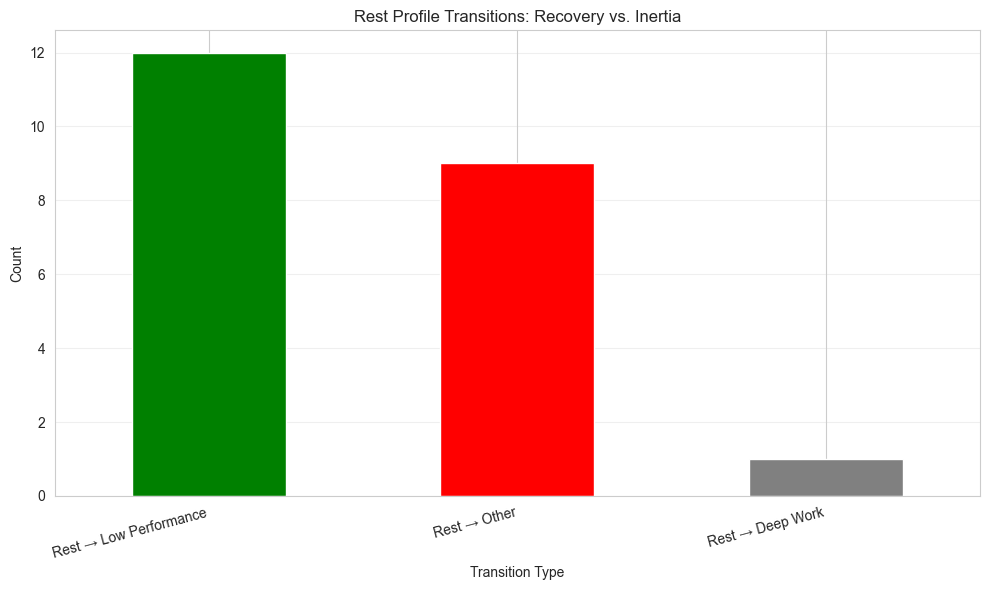


Chi-square test (Rest → Deep Work vs Rest → Low Performance):
  Observed: [np.int64(1), np.int64(12)]
  Expected: [np.float64(6.5), np.float64(6.5)]
  Chi-square statistic: 9.3077
  P-value: 0.0023
  Interpretation: Significant difference (α=0.05)


In [4]:
# Visualize transitions
transition_counts = transitions_df['transition_type'].value_counts()

plt.figure(figsize=(10, 6))
transition_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Rest Profile Transitions: Recovery vs. Inertia')
plt.xlabel('Transition Type')
plt.ylabel('Count')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical test: Chi-square test
# Compare Rest → Deep Work vs Rest → Low Performance
observed = [rest_to_deep_work, rest_to_low_perf]
# Expected frequencies must sum to the same as observed frequencies
# Assuming equal probability for the two categories being compared
total_compared = sum(observed)
expected = [total_compared / 2, total_compared / 2]  # Equal probability

if sum(observed) > 0 and total_compared >= 2:
    chi2, p_value = stats.chisquare(observed, expected)
    print("\nChi-square test (Rest → Deep Work vs Rest → Low Performance):")
    print(f"  Observed: {observed}")
    print(f"  Expected: {expected}")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} difference (α=0.05)")
else:
    print("\nInsufficient data for chi-square test (need at least 2 observations)")

## Hypothesis 5.2: Busy vs. Productive Distinction

**Hypothesis**: Can unsupervised clustering distinguish between "High-Volume / Low-Focus" days (Busywork) and "High-Volume / High-Focus" days (Flow State) based on the ratio of Work_Hours to Distraction_Time?

In [5]:
# Compute Work_Hours to Distraction_Time ratio
# Convert Distraction_Time_Mins to hours for ratio
df['Work_Distraction_Ratio'] = df['Work_Hours'] / (df['Distraction_Time_Mins'] / 60 + 0.001)  # Add small value to avoid division by zero

# Define high-volume days (top 50% of Work_Hours)
work_threshold = df['Work_Hours'].median()
df['High_Volume'] = df['Work_Hours'] >= work_threshold

# Define high-focus days (top 50% of Focus_Rating)
focus_threshold = df['Focus_Rating'].median()
df['High_Focus'] = df['Focus_Rating'] >= focus_threshold

# Categorize days
df['Productivity_Type'] = 'Low Volume'
df.loc[df['High_Volume'] & ~df['High_Focus'], 'Productivity_Type'] = 'Busywork (High Volume, Low Focus)'
df.loc[df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Flow State (High Volume, High Focus)'
df.loc[~df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Low Volume, High Focus'

print("Productivity Type Distribution:")
print(df['Productivity_Type'].value_counts())

print("\nProductivity Type by Cluster:")
crosstab = pd.crosstab(df['KMeans_Cluster'], df['Productivity_Type'], margins=True)
print(crosstab)

Productivity Type Distribution:
Productivity_Type
Flow State (High Volume, High Focus)    29
Low Volume, High Focus                  19
Low Volume                              18
Busywork (High Volume, Low Focus)       15
Name: count, dtype: int64

Productivity Type by Cluster:
Productivity_Type  Busywork (High Volume, Low Focus)  \
KMeans_Cluster                                         
0                                                 15   
1                                                  0   
2                                                  0   
All                                               15   

Productivity_Type  Flow State (High Volume, High Focus)  Low Volume  \
KMeans_Cluster                                                        
0                                                    29           3   
1                                                     0           7   
2                                                     0           8   
All                          

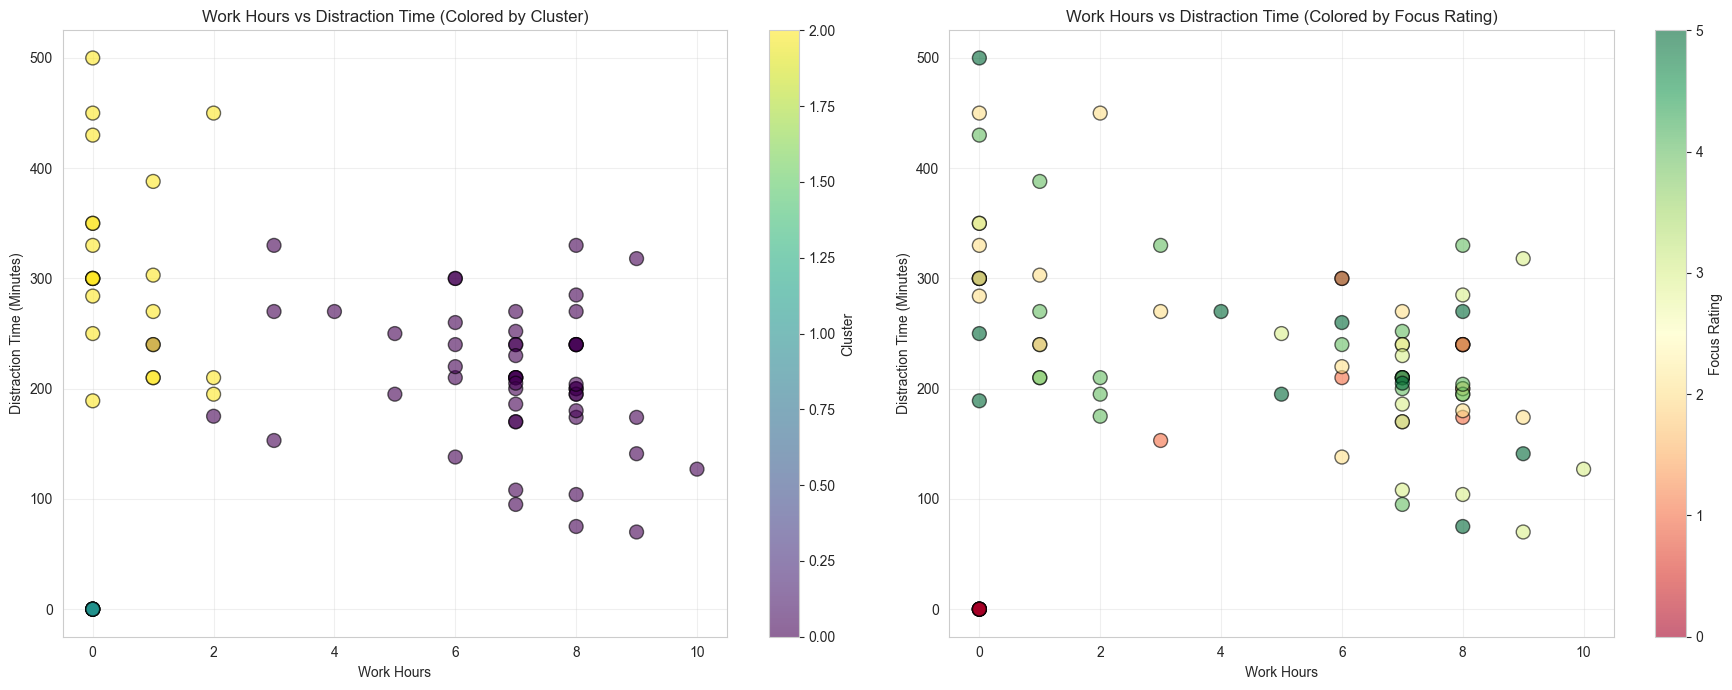

In [6]:
# Visualize Work_Hours vs Distraction_Time_Mins, colored by cluster and Focus_Rating
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by cluster
scatter1 = axes[0].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                          c=df['KMeans_Cluster'], cmap='viridis', 
                          s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('Work Hours')
axes[0].set_ylabel('Distraction Time (Minutes)')
axes[0].set_title('Work Hours vs Distraction Time (Colored by Cluster)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Colored by Focus_Rating
scatter2 = axes[1].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                          c=df['Focus_Rating'], cmap='RdYlGn', 
                          s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Work Hours')
axes[1].set_ylabel('Distraction Time (Minutes)')
axes[1].set_title('Work Hours vs Distraction Time (Colored by Focus Rating)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Focus Rating')

plt.tight_layout()
plt.show()

In [7]:
# Analyze if clusters naturally separate Busywork from Flow State
high_volume_days = df[df['High_Volume']].copy()

print("High-Volume Days Analysis:")
print("="*60)
print(f"Total high-volume days: {len(high_volume_days)}")
print("\nCluster distribution of high-volume days:")
print(high_volume_days['KMeans_Cluster'].value_counts().sort_index())

print("\nBusywork vs Flow State by Cluster:")
busywork_flow = high_volume_days.groupby('KMeans_Cluster')['Productivity_Type'].value_counts().unstack(fill_value=0)
print(busywork_flow)

# Check if clusters distinguish busywork from flow state
if 'Busywork (High Volume, Low Focus)' in busywork_flow.columns and 'Flow State (High Volume, High Focus)' in busywork_flow.columns:
    print("\nCluster separation of Busywork vs Flow State:")
    for cluster_id in busywork_flow.index:
        busywork_count = busywork_flow.loc[cluster_id, 'Busywork (High Volume, Low Focus)']
        flow_count = busywork_flow.loc[cluster_id, 'Flow State (High Volume, High Focus)']
        total = busywork_count + flow_count
        if total > 0:
            print(f"  Cluster {cluster_id} ({cluster_names[cluster_id]}):")
            print(f"    Busywork: {busywork_count}/{total} ({busywork_count/total*100:.1f}%)")
            print(f"    Flow State: {flow_count}/{total} ({flow_count/total*100:.1f}%)")

High-Volume Days Analysis:
Total high-volume days: 44

Cluster distribution of high-volume days:
KMeans_Cluster
0    44
Name: count, dtype: int64

Busywork vs Flow State by Cluster:
Productivity_Type  Busywork (High Volume, Low Focus)  \
KMeans_Cluster                                         
0                                                 15   

Productivity_Type  Flow State (High Volume, High Focus)  
KMeans_Cluster                                           
0                                                    29  

Cluster separation of Busywork vs Flow State:
  Cluster 0 (The Commuter Grind):
    Busywork: 15/44 (34.1%)
    Flow State: 29/44 (65.9%)


## Hypothesis 5.3: Weekend Bleed Effect

**Hypothesis**: Do specific habit profiles strictly align with calendar weekends, or do "Work/Study" profiles significantly intrude into weekends, and is this intrusion the strongest predictor of "Low Mood" clusters?

In [8]:
# Crosstab: cluster vs Is_Weekend
crosstab_weekend = pd.crosstab(df['KMeans_Cluster'], df['Is_Weekend'], 
                               margins=True, 
                               rownames=['Cluster'], 
                               colnames=['Is Weekend'])

print("Cluster Distribution by Weekend Status:")
print(crosstab_weekend)

# Calculate proportions
print("\nProportions:")
weekend_props = pd.crosstab(df['KMeans_Cluster'], df['Is_Weekend'], normalize='index') * 100
print(weekend_props.round(2))

Cluster Distribution by Weekend Status:
Is Weekend  False  True  All
Cluster                     
0              44     8   52
1               5     2    7
2               9    13   22
All            58    23   81

Proportions:
Is_Weekend      False  True 
KMeans_Cluster              
0               84.62  15.38
1               71.43  28.57
2               40.91  59.09


In [9]:
# Identify Work/Study profiles (Clusters 0 and 1)
work_study_clusters = [0, 1]  # Commuter Grind and Deep Work
df['Work_Study_Profile'] = df['KMeans_Cluster'].isin(work_study_clusters)

# Check if Work/Study profiles appear on weekends
weekend_work_study = df[df['Is_Weekend'] & df['Work_Study_Profile']]

print(f"Total weekend days: {df['Is_Weekend'].sum()}")
print(f"Weekend days with Work/Study profiles: {len(weekend_work_study)}")
print(f"Proportion: {len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%")

print("\nWeekend Work/Study Profile Breakdown:")
print(weekend_work_study['KMeans_Cluster'].value_counts().sort_index())

Total weekend days: 23
Weekend days with Work/Study profiles: 10
Proportion: 43.5%

Weekend Work/Study Profile Breakdown:
KMeans_Cluster
0    8
1    2
Name: count, dtype: int64


In [10]:
# Define Low Mood (bottom 50% of Mood_Rating)
mood_threshold = df['Mood_Rating'].median()
df['Low_Mood'] = df['Mood_Rating'] < mood_threshold

# Analyze Weekend + Work/Study intrusion vs Low Mood
print("Weekend Bleed Effect Analysis:")
print("="*60)

# Create categories
df['Weekend_Bleed'] = df['Is_Weekend'] & df['Work_Study_Profile']

# Compare mood across different scenarios
scenarios = {
    'Weekday + Work/Study': (~df['Is_Weekend']) & df['Work_Study_Profile'],
    'Weekend + Work/Study (Bleed)': df['Weekend_Bleed'],
    'Weekend + Rest': df['Is_Weekend'] & ~df['Work_Study_Profile'],
    'Weekday + Rest': (~df['Is_Weekend']) & ~df['Work_Study_Profile']
}

print("\nMood Rating by Scenario:")
for scenario_name, mask in scenarios.items():
    scenario_data = df[mask]
    if len(scenario_data) > 0:
        print(f"\n{scenario_name} (n={len(scenario_data)}):")
        print(f"  Mean Mood: {scenario_data['Mood_Rating'].mean():.2f}")
        print(f"  Low Mood Rate: {scenario_data['Low_Mood'].sum()}/{len(scenario_data)} ({scenario_data['Low_Mood'].mean()*100:.1f}%)")

Weekend Bleed Effect Analysis:

Mood Rating by Scenario:

Weekday + Work/Study (n=49):
  Mean Mood: 3.06
  Low Mood Rate: 17/49 (34.7%)

Weekend + Work/Study (Bleed) (n=10):
  Mean Mood: 2.80
  Low Mood Rate: 5/10 (50.0%)

Weekend + Rest (n=13):
  Mean Mood: 3.23
  Low Mood Rate: 4/13 (30.8%)

Weekday + Rest (n=9):
  Mean Mood: 3.78
  Low Mood Rate: 1/9 (11.1%)



Statistical Test: Weekend Bleed vs Weekend Rest
Weekend + Work/Study Mood: 2.80 ± 1.78
Weekend + Rest Mood: 3.23 ± 0.97

T-test:
  T-statistic: -0.7083
  P-value: 0.4866
  Interpretation: Not significant difference (α=0.05)


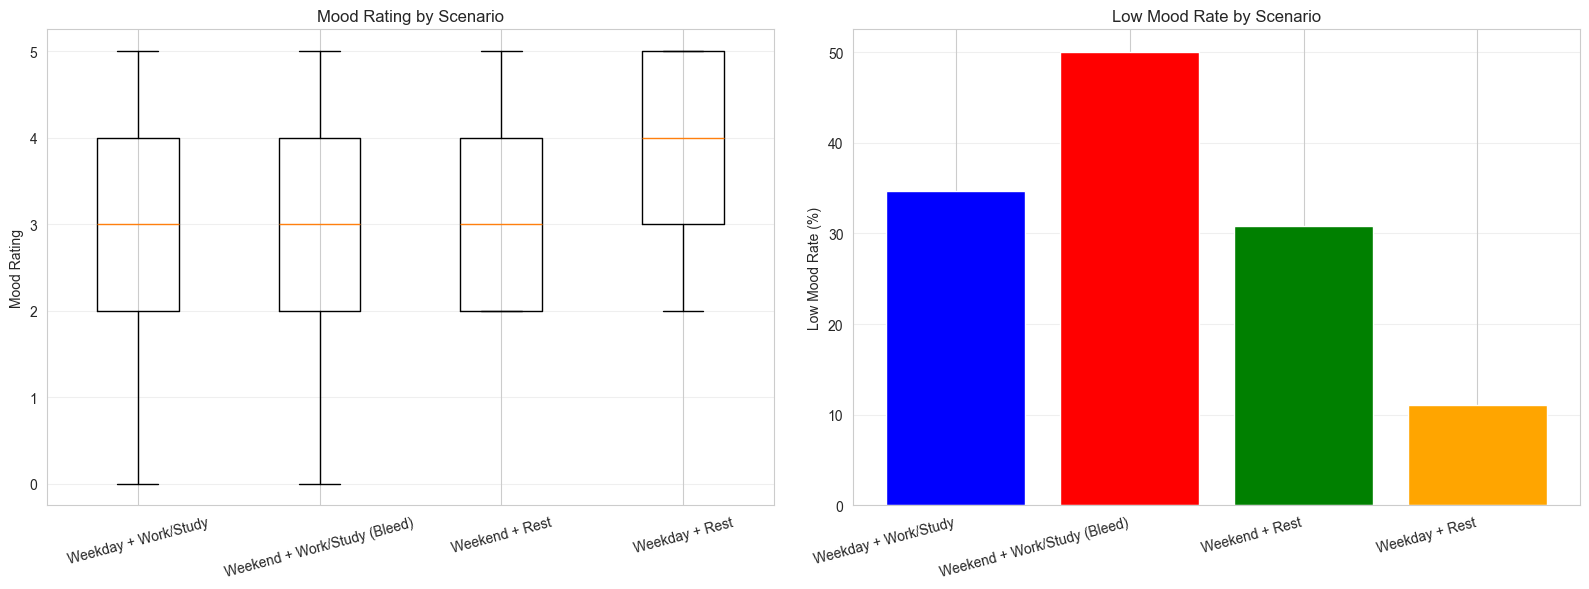

In [11]:
# Statistical test: Compare mood between Weekend+Bleed vs Weekend+Rest
weekend_bleed_mood = df[df['Weekend_Bleed']]['Mood_Rating'].values
weekend_rest_mood = df[df['Is_Weekend'] & ~df['Work_Study_Profile']]['Mood_Rating'].values

if len(weekend_bleed_mood) > 0 and len(weekend_rest_mood) > 0:
    t_stat, p_value = stats.ttest_ind(weekend_bleed_mood, weekend_rest_mood)
    
    print("\nStatistical Test: Weekend Bleed vs Weekend Rest")
    print("="*60)
    print(f"Weekend + Work/Study Mood: {weekend_bleed_mood.mean():.2f} ± {weekend_bleed_mood.std():.2f}")
    print(f"Weekend + Rest Mood: {weekend_rest_mood.mean():.2f} ± {weekend_rest_mood.std():.2f}")
    print(f"\nT-test:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} difference (α=0.05)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mood by scenario
scenario_moods = [df[mask]['Mood_Rating'].values for mask in scenarios.values()]
axes[0].boxplot(scenario_moods, labels=list(scenarios.keys()))
axes[0].set_ylabel('Mood Rating')
axes[0].set_title('Mood Rating by Scenario')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Low Mood rate by scenario
low_mood_rates = [df[mask]['Low_Mood'].mean() * 100 for mask in scenarios.values()]
axes[1].bar(range(len(scenarios)), low_mood_rates, color=['blue', 'red', 'green', 'orange'])
axes[1].set_xticks(range(len(scenarios)))
axes[1].set_xticklabels(list(scenarios.keys()), rotation=15, ha='right')
axes[1].set_ylabel('Low Mood Rate (%)')
axes[1].set_title('Low Mood Rate by Scenario')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary of Hypothesis Tests

In [12]:
# Compile summary
print("="*80)
print("HYPOTHESIS TESTING SUMMARY")
print("="*80)

print("\n1. Recovery vs. Inertia Hypothesis:")
if len(transitions_df) > 0:
    recovery_rate = rest_to_deep_work / len(transitions_df) * 100
    inertia_rate = rest_to_low_perf / len(transitions_df) * 100
    print(f"   Rest → Deep Work: {recovery_rate:.1f}%")
    print(f"   Rest → Low Performance: {inertia_rate:.1f}%")
    print(f"   Conclusion: {'Recovery' if recovery_rate > inertia_rate else 'Inertia'} pattern dominates")

print("\n2. Busy vs. Productive Distinction:")
print(f"   High-volume days: {len(high_volume_days)}")
if 'Busywork (High Volume, Low Focus)' in df['Productivity_Type'].values:
    busywork_count = (df['Productivity_Type'] == 'Busywork (High Volume, Low Focus)').sum()
    flow_count = (df['Productivity_Type'] == 'Flow State (High Volume, High Focus)').sum()
    print(f"   Busywork days: {busywork_count}")
    print(f"   Flow State days: {flow_count}")

print("\n3. Weekend Bleed Effect:")
print(f"   Weekend days with Work/Study profiles: {len(weekend_work_study)}/{df['Is_Weekend'].sum()} ({len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%)")
if len(weekend_bleed_mood) > 0 and len(weekend_rest_mood) > 0:
    print(f"   Weekend Bleed Mood: {weekend_bleed_mood.mean():.2f}")
    print(f"   Weekend Rest Mood: {weekend_rest_mood.mean():.2f}")
    print(f"   {'Weekend Bleed' if weekend_bleed_mood.mean() < weekend_rest_mood.mean() else 'No clear'} effect on mood")

HYPOTHESIS TESTING SUMMARY

1. Recovery vs. Inertia Hypothesis:
   Rest → Deep Work: 4.5%
   Rest → Low Performance: 54.5%
   Conclusion: Inertia pattern dominates

2. Busy vs. Productive Distinction:
   High-volume days: 44
   Busywork days: 15
   Flow State days: 29

3. Weekend Bleed Effect:
   Weekend days with Work/Study profiles: 10/23 (43.5%)
   Weekend Bleed Mood: 2.80
   Weekend Rest Mood: 3.23
   Weekend Bleed effect on mood


## Save Results

In [13]:
# Save updated dataframe with hypothesis analysis columns
df.to_csv('data/data_with_hypothesis_analysis.csv', index=False)

# Save transitions data
transitions_df.to_csv('data/recovery_inertia_transitions.csv', index=False)

print("Results saved:")
print("- data/data_with_hypothesis_analysis.csv")
print("- data/recovery_inertia_transitions.csv")

Results saved:
- data/data_with_hypothesis_analysis.csv
- data/recovery_inertia_transitions.csv
